#### Tuning XGB Adjuster: German Data

In [2]:
from aif360.algorithms.inprocessing.xgb_fairness_adjuster import XGBFairnessAdjuster
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_german,
)

#### Load dataset and set options

In [3]:
dataset_orig = load_preproc_data_german(["age", "sex"])
dataset_orig_train, dataset_orig_test = dataset_orig.split(
    [0.9], shuffle=True, seed=1234
)
privileged_groups = [{"age": 1}]
unprivileged_groups = [{"age": 0}]

/home/ubuntu/AIF360_dev/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['personal_status'].replace(status_map)


### Learn plan classifier without debiasing

In [4]:
base_settings = {
    "time_budget": 6000,  # total running time in seconds
    "metric": "log_loss",
}

In [5]:
plain_model = XGBFairnessAdjuster(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    debias=False,
    tune_hyperparameters_base=True,
    tuning_settings_base=base_settings,
    tune_hyperparameters_adjuster=False,
)

In [6]:
plain_model.fit(dataset=dataset_orig_train, test_dataset=dataset_orig_test)

### Apply in-processing algorithm based on adversarial learning

In [7]:
debiased_model = XGBFairnessAdjuster(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    seed=1234,
    debias=True,
    adversary_loss_weight=1.0,
    tune_hyperparameters_base=True,
    tuning_settings_base=base_settings,
    tune_hyperparameters_adjuster=False,
    debug=False,
    task="classification",
)

In [8]:
debiased_model.fit(dataset=dataset_orig_train, test_dataset=dataset_orig_test)

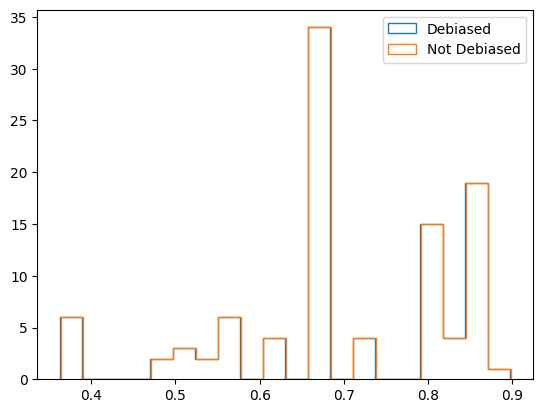

In [10]:
import matplotlib.pyplot as plt

bins = 20
probs_ad = debiased_model.predict_proba(dataset_orig_test)
base_probs = plain_model.predict_proba(dataset_orig_test)
# plt.hist(adjusted_probs, bins=bins, histtype="step", label="Fairness Adjuster")
plt.hist(probs_ad, bins=bins, histtype="step", label="Debiased")
plt.hist(base_probs, bins=bins, histtype="step", label="Not Debiased")
plt.legend()
plt.show()

In [14]:
plain_model.base_estimator.best_config

{'n_estimators': 4,
 'max_leaves': 183,
 'min_child_weight': 0.001,
 'learning_rate': 1.0,
 'subsample': np.float64(0.794149258757137),
 'colsample_bylevel': np.float64(0.7058998664178697),
 'colsample_bytree': np.float64(0.42240721131546477),
 'reg_alpha': np.float64(0.7574637704877069),
 'reg_lambda': 0.0009765625}

In [15]:
debiased_model.base_estimator.best_config

{'n_estimators': 4,
 'max_leaves': 183,
 'min_child_weight': 0.001,
 'learning_rate': 1.0,
 'subsample': np.float64(0.794149258757137),
 'colsample_bylevel': np.float64(0.7058998664178697),
 'colsample_bytree': np.float64(0.42240721131546477),
 'reg_alpha': np.float64(0.7574637704877069),
 'reg_lambda': 0.0009765625}